In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
data_set = pd.read_csv('Data/OnlineRetail.csv')

In [6]:
# DATA WRANGLING 



#Cleaning up all of the values equaled NaN

data_set = data_set[data_set['CustomerID'].notnull()]



#Converting the type of Invoice Date Field from string to datetime

data_set['InvoiceDate'] = pd.to_datetime(data_set['InvoiceDate'])


# THE FOCUS METRIC - Weekly active buyers (WAB)

In [7]:
#Considering the rows only for 2011

def f(x):
    
    if x.year == 2010: 
        
        return False 
    
    else: 
        
        return True

data_set = data_set[data_set['InvoiceDate'].map(f)]


In [8]:
#Writing the transformed data out to a file

data_set.to_csv('Results/transformed_data_set.csv')

In [ ]:

#It can be important to sort out the column before any manipulations


In [199]:
#Creating a series with day numbers from 2011-01-04 to 2011-12-09 (the first and last days in 2011 in the data)

# !!! Attention: in this data the store has purchases every day during the period  


day_numbers = pd.Series(range(len(data_set)))

invoice_date = pd.Series(data_set['InvoiceDate'])

month_number = invoice_date.iloc[0].month

last_month_day = 0


for i in range(len(data_set)): 
    
    if invoice_date.iloc[i].month == month_number:
        
        day_numbers[i] = invoice_date.iloc[i].day + last_month_day
        
    else: 
        
        month_number = invoice_date.iloc[i].month
        
        last_month_day = day_numbers[i-1]
        
        day_numbers[i] = invoice_date.iloc[i].day + last_month_day


In [200]:
#Creating a series with week numbers from 2011-01-04 to 2011-12-09


week_number = 1

days_in_a_week = 7

next_week_day = day_numbers[0] + days_in_a_week

week_numbers = pd.Series(range(len(data_set)))


for i in range(len(data_set)):
    
    if day_numbers[i] < next_week_day:
        
        week_numbers[i] = week_number
    
    else:
        
        next_week_day = next_week_day + days_in_a_week
        
        week_number = week_number + 1
        
        week_numbers[i] = week_number


In [201]:
#Adding the series to the table as a new field


data_set.index = range(len(data_set))

data_set['WeekNo'] = week_numbers

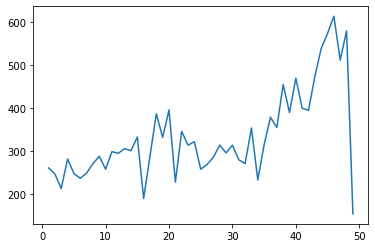

In [202]:
#Calculating WAB and visualizing the metric 


grouped = data_set['CustomerID'].groupby(data_set['WeekNo'])

WAB = grouped.apply(lambda x: pd.Series(x.unique()).count())

WAB.name = 'WAB'

WAB.index.name = ''



plt.plot(WAB.index, WAB)


In [209]:
#Writing the resulting data out to files

data_set.to_csv('Data/Data_set_with_weeks.csv')

WAB.to_csv('Results/WAB.csv')

# New active buyers by week

In [228]:
data_set = pd.read_csv('Data/Data_set_with_weeks.csv')

del data_set['Unnamed: 0']

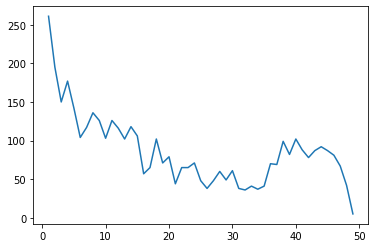

In [239]:
#Computing the count of new active buyers per week


#Getting unique customer IDs for every week

grouped = data_set['CustomerID'].groupby(data_set['WeekNo'])

unique_by_week = grouped.apply(lambda x: pd.Series(x.unique()))



number_of_weeks = data_set['WeekNo'].max()
  
ex_act_buyers = []

new_act_buyers_by_week = pd.Series(range(number_of_weeks))

new_act_buyers_by_week.index = new_act_buyers_by_week.index + 1

new_act_buyers = 0



for i in range(number_of_weeks):
    
    for j in range(len(unique_by_week.loc[i+1])):
        
        if unique_by_week.loc[i+1,j] not in ex_act_buyers:
            
            new_act_buyers = new_act_buyers + 1
            
            ex_act_buyers.append(unique_by_week.loc[i+1,j])
    
    new_act_buyers_by_week.iloc[i] = new_act_buyers
    
    new_act_buyers = 0
    

plt.plot(new_act_buyers_by_week.index, new_act_buyers_by_week) 

In [224]:
#Writing the resulting data out to a file

new_act_buyers_by_week.to_csv('Results/new_act_buyers_by_week.csv')

# Engagement

In [172]:
data_set = pd.read_csv('Data/Data_set_with_weeks.csv')

del data_set['Unnamed: 0']

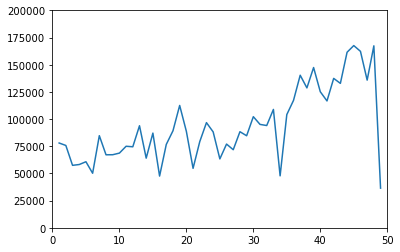

In [177]:
#As the key action is a purchase the engagement metric can be defined as the number of key actions taken by week


engagement = data_set['Quantity'].groupby(data_set['WeekNo']).sum()



limits = [0, 50, 0, 200000]

plt.axis(limits)

plt.plot(engagement.index, engagement)

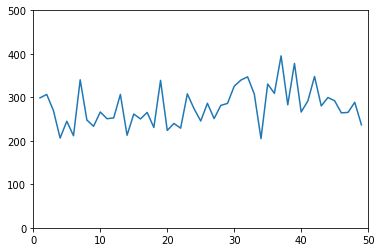

In [178]:
#It's important to determine engagement per user as well


WAB = pd.read_csv('WAB.csv')

WAB = WAB.set_index('Unnamed: 0')

WAB.index.name = 'WeekNo'

engagement_per_user = engagement / WAB['WAB']



limits = [0, 50, 0, 500]

plt.axis(limits)

plt.plot(engagement_per_user.index, engagement_per_user)

In [175]:
#Writing the resulting data out to a file

engagement_per_user.to_csv('Results/engagement_per_user.csv')

# Retention: 1-month buyer retention rate

In [179]:
data_set = pd.read_csv('Data/transformed_data_set.csv')

del data_set['Unnamed: 0']


In [180]:
#Converting the type of Invoice Date Field from string to datetime and adding a new column with month numbers

data_set['InvoiceDate'] = pd.to_datetime(data_set['InvoiceDate'])

data_set['MonthNo'] = data_set['InvoiceDate'].map(lambda x: x.month)


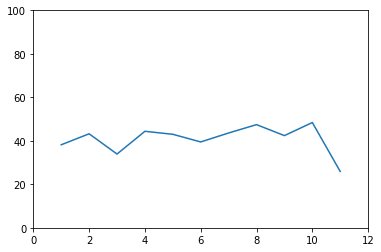

In [181]:
#Calculating 1-month buyer retention rate from January to November in 2011
#The data has no rows in January in 2012 so the retention rate for December in 2011 is not computed


#Using the crosstab() function to get unique customer IDs and their frequencies for each month

customers_months = pd.crosstab(data_set['CustomerID'],data_set['MonthNo'])



#Creating an empty table for statistics 

retention = pd.DataFrame(np.arange(22).reshape(11,2), columns=['Total_Active_Users','Retained_Active_Users'])

retention.index = retention.index + 1

retention.index.name = 'MonthNo'



#Calculating the total number of active users in a month and the retained number of active users in the next month

for i in range(len(customers_months.columns)-1):
    
    retention.iloc[i,0] = len(customers_months[customers_months[i+1] > 0])
    
    retention.iloc[i,1] = len(customers_months[(customers_months[i+1] > 0) & (customers_months[i+2] > 0)])

    

#Creating a new column and adding retention rates in 
    
retention['Retention_Rate'] = retention['Retained_Active_Users'] / retention['Total_Active_Users'] * 100



limits = [0, 12, 0, 100]

plt.axis(limits)

plt.plot(retention['Retention_Rate'].index, retention['Retention_Rate'])


In [182]:
#Writing the resulting data out to files

data_set.to_csv('Data/Data_set_with_months.csv')

retention.to_csv('Results/retention.csv')

# Retention: unbounded retention

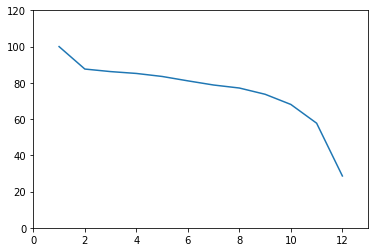

In [171]:
#To see what unbounded retention is read this article: https://amplitude.com/blog/3-ways-measure-user-retention



#Calculating unbounded retention only for the first month active buyers in 2011

customers_months = customers_months[customers_months[1] > 0]



#Creating and preparing a series for the metric

unbounded_retention = pd.Series(range(12), index=np.arange(1,13,1))

unbounded_retention[1] = len(customers_months)

number = 0



#Computing the total numbers of retained active buyers

for i in range(len(customers_months.columns)-1):
    
    for j in range(len(customers_months)):
            
        if (customers_months.iloc[j, i+1:] > 0).sum() > 0:
            
            number = number + 1
            
    unbounded_retention[i+2] = number
            
    number = 0



#Getting unbounded retention as a percentage    

unbounded_retention = unbounded_retention / unbounded_retention[1] * 100



limits = [0, 13, 0, 120]

plt.axis(limits)

plt.plot(unbounded_retention.index, unbounded_retention)


In [183]:
#Writing the resulting data out to files

unbounded_retention.to_csv('Results/unbounded_retention.csv')

# Retention analysis: cohorts based on months

In [401]:
data_set = pd.read_csv('Data/transformed_data_set.csv')

del data_set['Unnamed: 0']



#Converting the type of Invoice Date Field from string to datetime

data_set['InvoiceDate'] = pd.to_datetime(data_set['InvoiceDate'])


In [472]:
#In this section retention analysis is conducted grouping customers based on their first purchase dates 

#For our purpose it's only necessary to get columns 'InvoiceDate' and 'CustomerID'
#Because a purchase can have more than one items bought let's delete all the duplicates from the table

data_set = data_set[['CustomerID','InvoiceDate']].drop_duplicates()



#Adding a new column with month numbers when purchases were made 

data_set['MonthNo'] = data_set['InvoiceDate'].map(lambda x: x.month)

#data_set['OrderMonth'] = data_set['InvoiceDate'].dt.to_period('M')



#Adding a new column with month numbers when the first purchase was made for each customer 

data_set['Cohort'] = data_set['InvoiceDate'].groupby(data_set['CustomerID']).transform('min').map(lambda x: x.month)



#Computing the numbers of unique customers from one cohort making purchases in each month in 2011

cohort_month_customers = data_set.groupby(['Cohort','MonthNo']).agg(UniqCustomers = ('CustomerID','nunique')).reset_index()



#Creating a more visually appropriate table using the pivot table method 

retention_by_cohorts = cohort_month_customers.pivot_table(values = 'UniqCustomers', index = 'Cohort', columns = 'MonthNo') 



#To get the table with retention rates instead of absolute values let's take a series containing the total numbers of active 
#customers for each cohort 

total_active_customers = pd.Series(range(len(retention_by_cohorts.index)))

total_active_customers.index = retention_by_cohorts.index



for i in range(len(retention_by_cohorts.index)):
    
    total_active_customers[i+1] = cohort_month_customers[(cohort_month_customers['Cohort'] == i+1) & \
                                                         (cohort_month_customers['MonthNo'] == i+1)]['UniqCustomers']



#Eventually, absolute values are divided by total numbers and multiplied by 100 

retention_rates_by_cohorts = retention_by_cohorts.divide(s, axis = 0) * 100



#Rounding the values to one decimals and changing columns names

retention_rates_by_cohorts = retention_rates_by_cohorts.applymap(lambda x: round(x, 1))

retention_rates_by_cohorts.columns = data_set['InvoiceDate'].dt.to_period('M').drop_duplicates()

retention_rates_by_cohorts

InvoiceDate,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12
Cohort,,,,,,,,,,,,
1,100.0,38.2,44.2,39.0,45.8,43.3,40.1,39.7,44.3,43.4,52.7,28.6
2,NaN,100.0,28.9,25.1,33.9,31.7,27.9,30.5,33.9,31.5,36.9,14.8
3,NaN,NaN,100.0,20.6,27.2,24.2,23.2,19.6,28.5,24.7,31.1,10.8
4,NaN,NaN,NaN,100.0,25.0,25.0,23.9,21.7,24.4,25.0,29.2,9.2
5,NaN,NaN,NaN,NaN,100.0,23.0,18.0,18.3,23.0,25.2,27.4,10.7
6,NaN,NaN,NaN,NaN,NaN,100.0,21.3,18.3,25.5,24.0,33.8,10.3
7,NaN,NaN,NaN,NaN,NaN,NaN,100.0,20.6,21.6,24.3,26.6,13.8
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,25.5,25.5,26.1,14.7
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,29.7,33.2,12.5


In [473]:
#Writing the resulting data out to files

retention_rates_by_cohorts.to_csv('Results/retention_rates_by_cohorts.csv')